In [1]:
cd /data/a/cpac/isultan/projects/halomassloss/core_catalog_mevolved

/data/a/cpac/isultan/projects/halomassloss/core_catalog_mevolved


In [2]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import subhalo_mass_loss_model_ALCC as SHMLM_HM
import subhalo_mass_loss_model_LJDS as SHMLM_SV
import genericio as gio
from tqdm import tqdm
from itk import hist, h5_read_dict, gio_read_dict, loadpickle, plt_latex, periodic_bcs, many_to_one
from cc_generate_fitting_dt_ALCC import m_evolved_col, A_arr, zeta_arr
from scipy import spatial #KD Tree for subhalo-core matching
from scipy.stats import norm # Gaussian fitting
import itertools as it
massbinsize = 0.5

In [3]:
step = 499
#step = 247
assert SHMLM_HM.step2z[step] == SHMLM_SV.step2z[step], "Redshifts of HM and SV don't match."
z = SHMLM_HM.step2z[step]

In [4]:
cc_HM = h5_read_dict('/home/isultan/projects/halomassloss/core_catalog_mevolved/output_ALCC_localhost_dtfactor_0.5/{}.corepropertiesextend.hdf5'.format(step), 'coredata')

In [151]:
cc_SV = h5_read_dict('/home/isultan/projects/halomassloss/core_catalog_mevolved/output_LJDS_localhost_dtfactor_0.5_fitting2/m000p-{}.corepropertiesextend.hdf5'.format(step), 'coredata')
# mt_cores = gio_read_dict('/home/isultan/data/LJDS/MergerTrees_updated/m000p-{}.treenodes'.format(step), ['fof_halo_tag', 'fof_halo_mass', 'fof_halo_center_x', 'fof_halo_center_y', 'fof_halo_center_z'])
sh = gio_read_dict('/home/isultan/data/LJDS/subhalos/m000p-{}.subhaloproperties'.format(step), ['fof_halo_tag','subhalo_mean_x','subhalo_mean_y','subhalo_mean_z','subhalo_mean_vx', 'subhalo_mean_vy', 'subhalo_mean_vz', 'subhalo_count', 'subhalo_tag', 'subhalo_mass'])
mt = gio_read_dict('/home/isultan/data/LJDS/subhalos/m000p-{}.haloproperties'.format(step), ['fof_halo_tag', 'fof_halo_mass', 'fof_halo_center_x', 'fof_halo_center_y', 'fof_halo_center_z'])

In [156]:
cc_HM['infall_fof_halo_mass'] = gio.gio_read('/home/isultan/data/ALCC/CoreCatalog/{}.coreproperties'.format(step), 'infall_fof_halo_mass')[0] #cc_HM['infall_fof_halo_mass']
# cc_HM['infall_mass'] = cc_HM['infall_fof_halo_mass']
# cc_SV['infall_mass'] = cc_SV['infall_fof_halo_mass']
cc_HM['infall_mass'] = cc_HM['infall_tree_node_mass']
cc_SV['infall_mass'] = cc_SV['infall_tree_node_mass']

In [79]:
np.array_equal(cc_HM['infall_tree_node_mass'][(cc_HM['central']==1)&(cc_HM['fof_halo_tag']>=0)], cc_HM['infall_fof_halo_mass'][(cc_HM['central']==1)&(cc_HM['fof_halo_tag']>=0)])

True

In [83]:
np.sum((cc_HM['infall_tree_node_mass'][cc_HM['central']==1]>=10**12)&(cc_HM['infall_tree_node_mass'][cc_HM['central']==1]<=10**12.5))

30462

In [81]:
np.sum((cc_HM['infall_fof_halo_mass'][cc_HM['central']==1]>=10**12)&(cc_HM['infall_fof_halo_mass'][cc_HM['central']==1]<=10**12.5))

305487

In [85]:
print np.sum((cc_HM['infall_tree_node_mass'][cc_HM['central']==1]>=10**11)&(cc_HM['infall_tree_node_mass'][cc_HM['central']==1]<=10**11.5))
print np.sum((cc_HM['infall_fof_halo_mass'][cc_HM['central']==1]>=10**11)&(cc_HM['infall_fof_halo_mass'][cc_HM['central']==1]<=10**11.5))

print np.sum((cc_HM['infall_tree_node_mass'][cc_HM['central']==1]>=10**12)&(cc_HM['infall_tree_node_mass'][cc_HM['central']==1]<=10**12.5))
print np.sum((cc_HM['infall_fof_halo_mass'][cc_HM['central']==1]>=10**12)&(cc_HM['infall_fof_halo_mass'][cc_HM['central']==1]<=10**12.5))

print np.sum((cc_HM['infall_tree_node_mass'][cc_HM['central']==1]>=10**13)&(cc_HM['infall_tree_node_mass'][cc_HM['central']==1]<=10**13.5))
print np.sum((cc_HM['infall_fof_halo_mass'][cc_HM['central']==1]>=10**13)&(cc_HM['infall_fof_halo_mass'][cc_HM['central']==1]<=10**13.5))

308529
527421
30462
305487
2078
193564


In [86]:
print np.sum((cc_SV['infall_tree_node_mass'][cc_SV['central']==1]>=10**11)&(cc_SV['infall_tree_node_mass'][cc_SV['central']==1]<=10**11.5))
print np.sum((cc_SV['infall_fof_halo_mass'][cc_SV['central']==1]>=10**11)&(cc_SV['infall_fof_halo_mass'][cc_SV['central']==1]<=10**11.5))
 
print np.sum((cc_SV['infall_tree_node_mass'][cc_SV['central']==1]>=10**12)&(cc_SV['infall_tree_node_mass'][cc_SV['central']==1]<=10**12.5))
print np.sum((cc_SV['infall_fof_halo_mass'][cc_SV['central']==1]>=10**12)&(cc_SV['infall_fof_halo_mass'][cc_SV['central']==1]<=10**12.5))
 
print np.sum((cc_SV['infall_tree_node_mass'][cc_SV['central']==1]>=10**13)&(cc_SV['infall_tree_node_mass'][cc_SV['central']==1]<=10**13.5))
print np.sum((cc_SV['infall_fof_halo_mass'][cc_SV['central']==1]>=10**13)&(cc_SV['infall_fof_halo_mass'][cc_SV['central']==1]<=10**13.5))

351750
342721
33812
51048
2246
17142


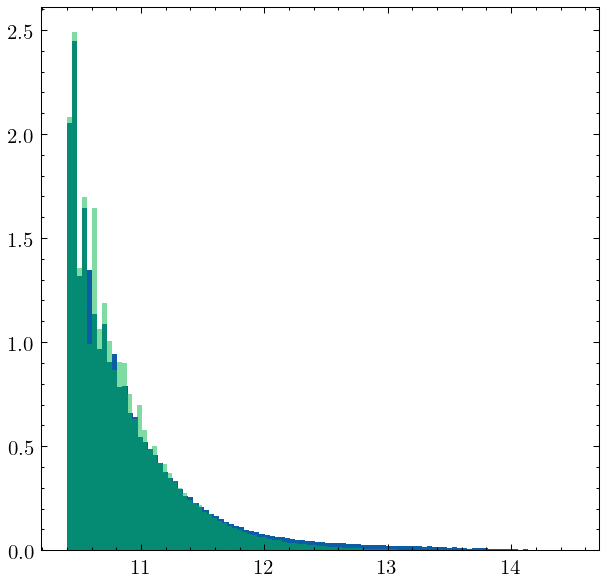

In [63]:
plt.hist(np.log10(cc_SV['infall_fof_halo_mass'][cc_SV['central']==1]), bins=100, density=True);
plt.hist(np.log10(cc_SV['infall_tree_node_mass'][cc_SV['central']==1]), bins=100, alpha=0.5, density=True);

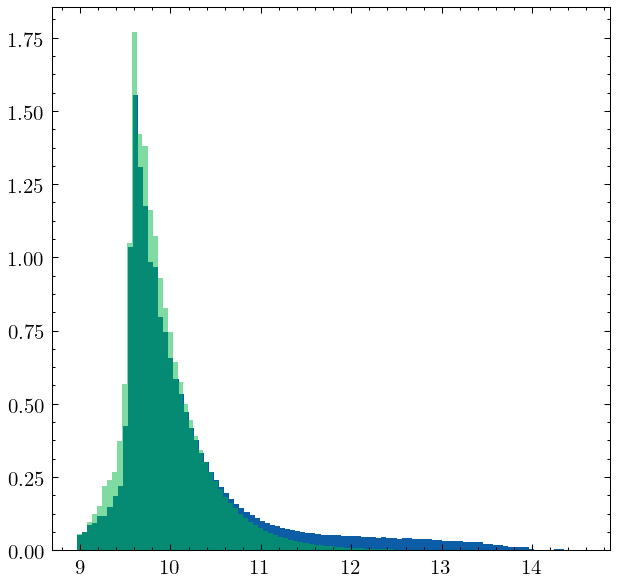

In [65]:
plt.hist(np.log10(cc_HM['infall_mass'][cc_HM['central']==1]), bins=100, density=True);
plt.hist(np.log10(cc_HM['infall_tree_node_mass'][cc_HM['central']==1]), bins=100, alpha=0.5, density=True);

In [38]:
np.sum((cc_SV['infall_tree_node_mass'][cc_SV['central']==1]>=10**11)&(cc_SV['infall_tree_node_mass'][cc_SV['central']==1]<=10**11.5))

351750

In [40]:
np.sum((cc_SV['infall_fof_halo_mass'][cc_SV['central']==1]>=10**11)&(cc_SV['infall_fof_halo_mass'][cc_SV['central']==1]<=10**11.5))

342721

In [47]:
np.sum(cc_SV['infall_fof_halo_tag']<0)

205132

In [48]:
np.sum(cc_HM['infall_fof_halo_tag']<0)

4468416

In [157]:
# Subhalo-core matching: to look at the subhalo mass:core evolved mass ratio
def generate_cores_kdtree(M1, M2, cc, SHMLM, s1=False, disrupt=None, onlyFiltered=False, giveFragmentsFofMass=False, mt_cores=None):
    # idx_filteredsatcores, M, X, Y, Z, nHalo = SHMLM.core_mask(cc, M1=10**8, M2=10**16, s1=s1, disrupt=disrupt, z=z)
    idx_filteredsatcores, M, X, Y, Z, nHalo = SHMLM.core_mask(cc, M1, M2, s1=s1, disrupt=disrupt, z=z)
    cc_filtered = { k:cc[k][idx_filteredsatcores].copy() for k in cc.keys() }
    cc_filtered['M'] = M
    if giveFragmentsFofMass:
        fragmask = cc_filtered['fof_halo_tag']<0
        frag_realfht = np.bitwise_and(cc_filtered['fof_halo_tag'][fragmask]*-1, 0xffffffffffff)
        idx_m21 = many_to_one( frag_realfht, mt_cores['fof_halo_tag'] )
        cc_filtered['M'][fragmask] = mt_cores['fof_halo_mass'][idx_m21]

    cc_filtered['x'] = SHMLM.periodic_bcs(cc_filtered['x'], X, SHMLM.BOXSIZE)
    cc_filtered['y'] = SHMLM.periodic_bcs(cc_filtered['y'], Y, SHMLM.BOXSIZE)
    cc_filtered['z'] = SHMLM.periodic_bcs(cc_filtered['z'], Z, SHMLM.BOXSIZE)
    Mmask = (M1 <= cc_filtered['M']) & (cc_filtered['M'] <= M2)
    cc_filtered = { k:cc_filtered[k][Mmask].copy() for k in cc_filtered.keys() }
    if onlyFiltered:
        return nHalo, cc_filtered
    else:
        return spatial.cKDTree( np.vstack((cc_filtered['x'], cc_filtered['y'], cc_filtered['z'])).T ), cc_filtered, nHalo

In [162]:
def subhalo_core_mass_plots(A, zeta, M1, M2, plotFlag, residualRange, normLogCntsFlag=True, logmOverMFlag=False, phaseMergedFlag=False, normCnts=False, MdepPlots=False, vlinepart=True, normScalar=False, normBinsize=False, shPlot=True, part100cutFlag=False, bins=50, ratio=False, plotHMFlag=True):
    """Plots subhalo and core mass histogram for all satellite subhalos and cores with at least 100 particles.
    Returns their residual (L2 norm) in `residualRange`."""
    if MdepPlots:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=[4.8*2,4.8*1.5], dpi=150)
#         fig.suptitle('z={}'.format(z))

        for ax,lM in zip([ax1, ax2, ax3, ax4],Mlist):
            M1, M2 = 10**lM, 10**(lM+massbinsize)
            # ax.set_title( '{} $\leq$ log(M/$h^{{-1}}M_\odot$)$\leq$ {}'.format(np.log10(M1),np.log10(M2)) )

            nH_core_SV, cc_filtered_SV = cc_filtered_dict_SV[lM]
            
            nH_core_HM, cc_filtered_HM = cc_filtered_dict_HM[lM]

            if part100cutFlag:
                cores100mask_SV = cc_filtered_SV[m_evolved_col(A, zeta)]>=SHMLM_SV.PARTICLECUTMASS
                if plotHMFlag:
                    cores100mask_HM = cc_filtered_HM[m_evolved_col(A, zeta)]>=SHMLM_HM.PARTICLECUTMASS
            else:
                cores100mask_SV = np.full_like(cc_filtered_SV[m_evolved_col(A, zeta)]>=0, True)
                if plotHMFlag:
                    cores100mask_HM = np.full_like(cc_filtered_HM[m_evolved_col(A, zeta)]>=0, True)

            nH_sh_param, nH_cHM_param, nH_cSV_param = 1,1,1
            if logmOverMFlag:
                r = (-3, 0)
                if part100cutFlag:
                    shmf, nH_sh = shmfdict_cut100[lM]
                else:
                    shmf, nH_sh = shmfdict[lM]
                if normScalar:
                    nH_sh_param = nH_core_SV #nH_sh
                    nH_cHM_param = nH_core_HM
                    nH_cSV_param = nH_core_SV
                print 'nH_sh_param: ', nH_sh_param
                print 'nH_cSV_param: ', nH_cSV_param
                print 'nH_cHM_param: ', nH_cHM_param
                print ''
                if ratio:
                    plotFlag = False  
                if shPlot:
                    sh_xarr, sh_cnts = hist(np.log10(shmf), bins=bins, normed=True, normBinsize=normBinsize, normCnts=normCnts, normLogCnts=normLogCntsFlag, normScalar=nH_sh_param, plotFlag=plotFlag, label='subhalos SV', alpha=.7, range=r, ax=ax)

                cmf_SV = cc_filtered_SV[m_evolved_col(A, zeta)][cores100mask_SV] / cc_filtered_SV['M'][cores100mask_SV]
                cores_xarr_SV, cores_cnts_SV = hist(np.log10(cmf_SV), bins=bins, normed=True, plotFlag=plotFlag, label='cores SV', alpha=.7, range=r, normScalar=nH_cSV_param, normCnts=normCnts, normBinsize=normBinsize, normLogCnts=normLogCntsFlag, ax=ax)

                if plotHMFlag:
                    cmf_HM = cc_filtered_HM[m_evolved_col(A, zeta)][cores100mask_HM] / cc_filtered_HM['M'][cores100mask_HM]
                    cores_xarr_HM, cores_cnts_HM = hist(np.log10(cmf_HM), bins=bins, normed=True, plotFlag=plotFlag, label='cores HM', alpha=1, range=r, normScalar=nH_cHM_param, normCnts=normCnts, normBinsize=normBinsize, normLogCnts=normLogCntsFlag, ax=ax)
                
                if ratio:
#                     assert np.array_equal(sh_xarr, cores_xarr_SV) and np.array_equal(cores_xarr_SV, cores_xarr_HM)
                    isfin_SV = np.isfinite(10**(cores_cnts_SV-sh_cnts))
                    ax.axhline(1, ls='--', alpha=1, zorder=0, c='k')
                    ax.plot(sh_xarr[isfin_SV], (10**(cores_cnts_SV-sh_cnts))[isfin_SV], label='cores/subhalos (SV)')
                    
                    if plotHMFlag:
                        isfin_HM = np.isfinite(10**(cores_cnts_HM-sh_cnts))
                        ax.plot(sh_xarr[isfin_HM], (10**(cores_cnts_HM-sh_cnts))[isfin_HM], label='cores HM')
                    
                    ax.set_xlim(-3.2, 0)
                    ax.set_ylim(0, 3.4)
                else:
                    ax.set_xlim(-3.2, 0)
#                     ax.set_ylim(-2, 1.4)
#                     ax.set_xlabel(r'$\log(m/M)$')
#                     ax.set_ylabel(r'$\log \left[ \mathrm{d}N/\mathrm{d} \log(m/M) \right]$')
            else:
                #r = (9, 15)
                r = (np.log10(SHMLM_HM.PARTICLECUTMASS/100.), 15)
                if part100cutFlag:
                    shmf, nH = shfdict_cut100[lM]
                else:
                    shmf, nH = shfdict[lM]
                if normScalar:
                    nH_sh_param = nH_core_SV #nH_sh
                    nH_cHM_param = nH_core_HM
                    nH_cSV_param = nH_core_SV
                print 'nH_sh_param: ', nH_sh_param
                print 'nH_cSV_param: ', nH_cSV_param
                print 'nH_cHM_param: ', nH_cHM_param
                print '' 
                if shPlot:
                    sh_xarr, sh_cnts = hist(np.log10(shmf), bins=bins, normed=True, normBinsize=normBinsize, normCnts=normCnts, normLogCnts=normLogCntsFlag, normScalar=nH_sh_param, plotFlag=plotFlag, label='subhalos SV', alpha=1, range=r, ax=ax)

                cmf_SV = cc_filtered_SV[m_evolved_col(A, zeta)][cores100mask_SV]
                cores_xarr_SV, cores_cnts_SV = hist(np.log10(cmf_SV), bins=bins, normed=True, plotFlag=plotFlag, label='cores SV', alpha=1, range=r, normScalar=nH_cHM_param, normCnts=normCnts, normBinsize=normBinsize, normLogCnts=normLogCntsFlag, ax=ax)
                if plotHMFlag:
                    cmf_HM = cc_filtered_HM[m_evolved_col(A, zeta)][cores100mask_HM]
                    cores_xarr_HM, cores_cnts_HM = hist(np.log10(cmf_HM), bins=bins, normed=True, plotFlag=plotFlag, label='cores HM', alpha=1, range=r, normScalar=nH_cHM_param, normCnts=normCnts, normBinsize=normBinsize, normLogCnts=normLogCntsFlag, ax=ax)

                ax.set_ylim(-5, 3.6)
                ax.set_xlim(7.5, 14.2)
                if vlinepart:
                    ax.axvline(x=np.log10(SHMLM_SV.PARTICLES100MASS), c='r', lw=0.5, label='100 part. SV', ymax=0.90)
                    ax.axvline(x=np.log10(SHMLM_HM.PARTICLES100MASS), c='k', lw=0.5, label='100 part. HM')
                    # ax.axvline(x=np.log10(SHMLM.PARTICLES100MASS/100.*20), c='r', lw=0.5, label='20 part.')

            assert np.array_equal(cores_xarr_SV, sh_xarr)
            ##ax.set_title( '[{},{}]'.format(np.log10(M1),np.log10(M2)) )
            ax.set_title( '{} $\leq$ log(M/$h^{{-1}}M_\odot$)$\leq$ {}'.format(np.log10(M1),np.log10(M2)), pad=-16, x=0.60 )
            ##ax.text(0.5, 0.7, 'sh:{}'.format(np.format_float_scientific(len(shmf))), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
            ##ax.text(0.5, 0.6, 'c:{}'.format(np.format_float_scientific(len(cmf))), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
            ##ax.text(0.5, 0.5, 'H:{}'.format(np.format_float_scientific(nH)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
        if logmOverMFlag:
            fig.text(0.5,0.08, r'$\log(m/M)$', ha="center", va="center")
            if ratio:
                fig.text(0.08,0.5, r'ratio $\left[ \mathrm{d}N/\mathrm{d} \log(m/M) \right]$', ha="center", va="center", rotation=90)
            else:
                fig.text(0.08,0.5, r'$\log \left[ \mathrm{d}N/\mathrm{d} \log(m/M) \right]$', ha="center", va="center", rotation=90)
        else:
            fig.text(0.5,0.08, r'$\log(m)$', ha="center", va="center")
            fig.text(0.08,0.5, r'$\log \left[ \mathrm{d}N/\mathrm{d} \log(m) \right]$', ha="center", va="center", rotation=90)
        ax4.legend(loc=4)
        return fig, ((ax1, ax2), (ax3, ax4))
    else:
        # sh_mask = (sh['subhalo_tag']!=0)&(M1<=sh['M'])&(sh['M']<=M2)#&(distance_mask) #&(sh['subhalo_mass']>=SHMLM.SUBHALOMASSCUT)
        # sh100mask = sh['subhalo_mass'][sh_mask]>=SHMLM.PARTICLECUTMASS
        # cores_tree, cc_filtered, nHalo = generate_cores_kdtree(M1=M1, M2=M2, s1=False, disrupt=None)
        cores100mask = cc_filtered[m_evolved_col(A, zeta)]>=SHMLM.PARTICLECUTMASS
        if phaseMergedFlag:
            cores100mask = cores100mask&(cc_filtered['phaseSpaceMerged']!=1)
        if logmOverMFlag:
            r = (-3, 0)
            shmf = sh['subhalo_mass'][sh_mask][sh100mask] / sh['M'][sh_mask][sh100mask]
            sh_xarr, sh_cnts = hist(np.log10(shmf), bins=bins, normed=True, normBinsize=False, normCnts=normCnts, normLogCnts=normLogCntsFlag, normScalar=1, plotFlag=plotFlag, label='subhalos', alpha=1, range=r)

            cmf = cc_filtered[m_evolved_col(A, zeta)][cores100mask] / cc_filtered['M'][cores100mask]
            cores_xarr, cores_cnts = hist(np.log10(cmf), bins=bins, normed=True, plotFlag=plotFlag, label='cores', alpha=1, range=r, normScalar=1, normCnts=normCnts, normBinsize=False, normLogCnts=normLogCntsFlag)
        else:
            r = (9, 15)
            shmf = sh['subhalo_mass'][sh_mask][sh100mask]
            sh_xarr, sh_cnts = hist(np.log10(shmf), bins=bins, normed=True, normBinsize=False, normCnts=normCnts, normLogCnts=normLogCntsFlag, normScalar=1, plotFlag=plotFlag, label='subhalos', alpha=1, range=r)

            cmf = cc_filtered[m_evolved_col(A, zeta)][cores100mask]
            cores_xarr, cores_cnts = hist(np.log10(cmf), bins=bins, normed=True, plotFlag=plotFlag, label='cores', alpha=1, range=r, normScalar=1, normCnts=normCnts, normBinsize=False, normLogCnts=normLogCntsFlag)
        assert np.array_equal(cores_xarr, sh_xarr)
        # print sh_cnts, cores_cnts
        res_mask = (residualRange[0]<=sh_xarr)&(sh_xarr<=residualRange[1])
        return np.linalg.norm(np.true_divide(((sh_cnts-cores_cnts)[res_mask]), sh_cnts[res_mask]))

In [178]:
sh['rvir'] = SHMLM_SV.getRvir(sh['subhalo_mass'], z)

idx_m21_sh = many_to_one(sh['fof_halo_tag'], mt['fof_halo_tag'])
sh['M'] = mt['fof_halo_mass'][idx_m21_sh]

# Mlist = [11,12,13,14]
Mlist = [12,12.5,13,14]
def shmf_gen(lM, shfFlag=False, part100cutFlag=False):
    M1, M2 = 10**lM, 10**(lM+massbinsize)
    sh_mask = (sh['subhalo_tag']!=0)&(M1<=sh['M'])&(sh['M']<=M2)
    if part100cutFlag:
        sh100mask = sh['subhalo_mass'][sh_mask]>=SHMLM_SV.PARTICLECUTMASS
    else:
        sh100mask = np.full_like(sh['subhalo_mass'][sh_mask]>=0, True)
    if shfFlag:
        shmf = sh['subhalo_mass'][sh_mask][sh100mask]
    else:
        shmf = sh['subhalo_mass'][sh_mask][sh100mask] / sh['M'][sh_mask][sh100mask]
    nH = len(np.unique(sh['fof_halo_tag'][sh_mask]))
    return (shmf, nH)
def cc_filtered_gen(lM, cc, SHMLM):
    M1, M2 = 10**lM, 10**(lM+massbinsize)
    return generate_cores_kdtree(M1, M2, cc, SHMLM, s1=False, disrupt=None, onlyFiltered=True, giveFragmentsFofMass=False, mt_cores=None)

shmfdict = {k:shmf_gen(k) for k in Mlist}
shfdict = {k:shmf_gen(k, shfFlag=True) for k in Mlist}

shmfdict_cut100 = {k:shmf_gen(k, part100cutFlag=True) for k in Mlist}
shfdict_cut100 = {k:shmf_gen(k, shfFlag=True, part100cutFlag=True) for k in Mlist}

cc_filtered_dict_SV = {k:cc_filtered_gen(k, cc_SV, SHMLM_SV) for k in Mlist}
cc_filtered_dict_HM = {k:cc_filtered_gen(k, cc_HM, SHMLM_HM) for k in Mlist}

In [136]:
plt.style.use(['science', 'high-vis'])

nH_sh_param:  40628
nH_cSV_param:  40628
nH_cHM_param:  39505

nH_sh_param:  14286
nH_cSV_param:  14286
nH_cHM_param:  13733

nH_sh_param:  4797
nH_cSV_param:  4797
nH_cHM_param:  4738

nH_sh_param:  337
nH_cSV_param:  337
nH_cHM_param:  348



/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in subtract
/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in subtract


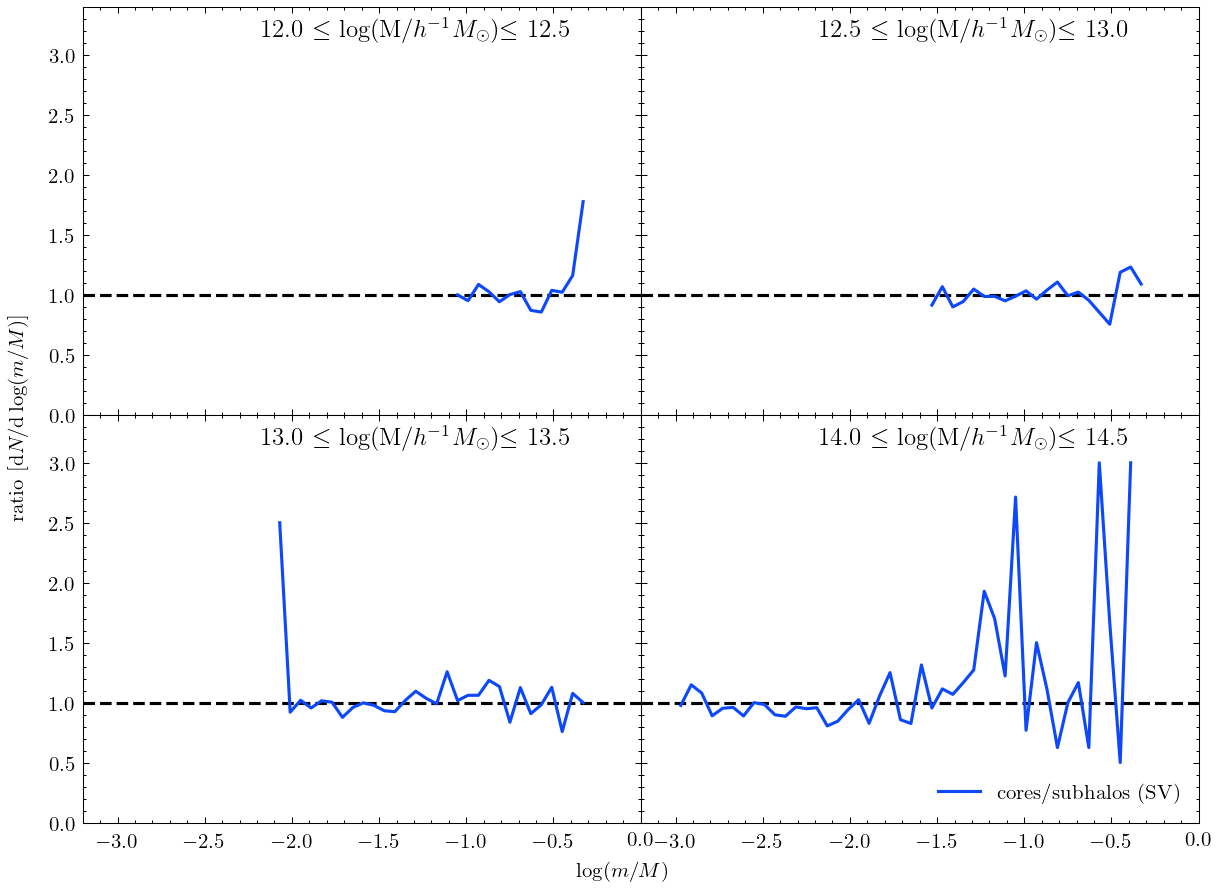

In [150]:
subhalo_core_mass_plots(A=0.9, zeta=0.005, M1=0, M2=0, plotFlag=1, residualRange=(0,0), normLogCntsFlag=True, logmOverMFlag=1, phaseMergedFlag=0, normCnts=0, MdepPlots=1, vlinepart=0, normScalar=1, normBinsize=1, shPlot=1, part100cutFlag=1, plotHMFlag=False, ratio=True);

nH_sh_param:  40628
nH_cSV_param:  40628
nH_cHM_param:  39505

nH_sh_param:  14286
nH_cSV_param:  14286
nH_cHM_param:  13733

nH_sh_param:  4797
nH_cSV_param:  4797
nH_cHM_param:  4738

nH_sh_param:  337
nH_cSV_param:  337
nH_cHM_param:  348



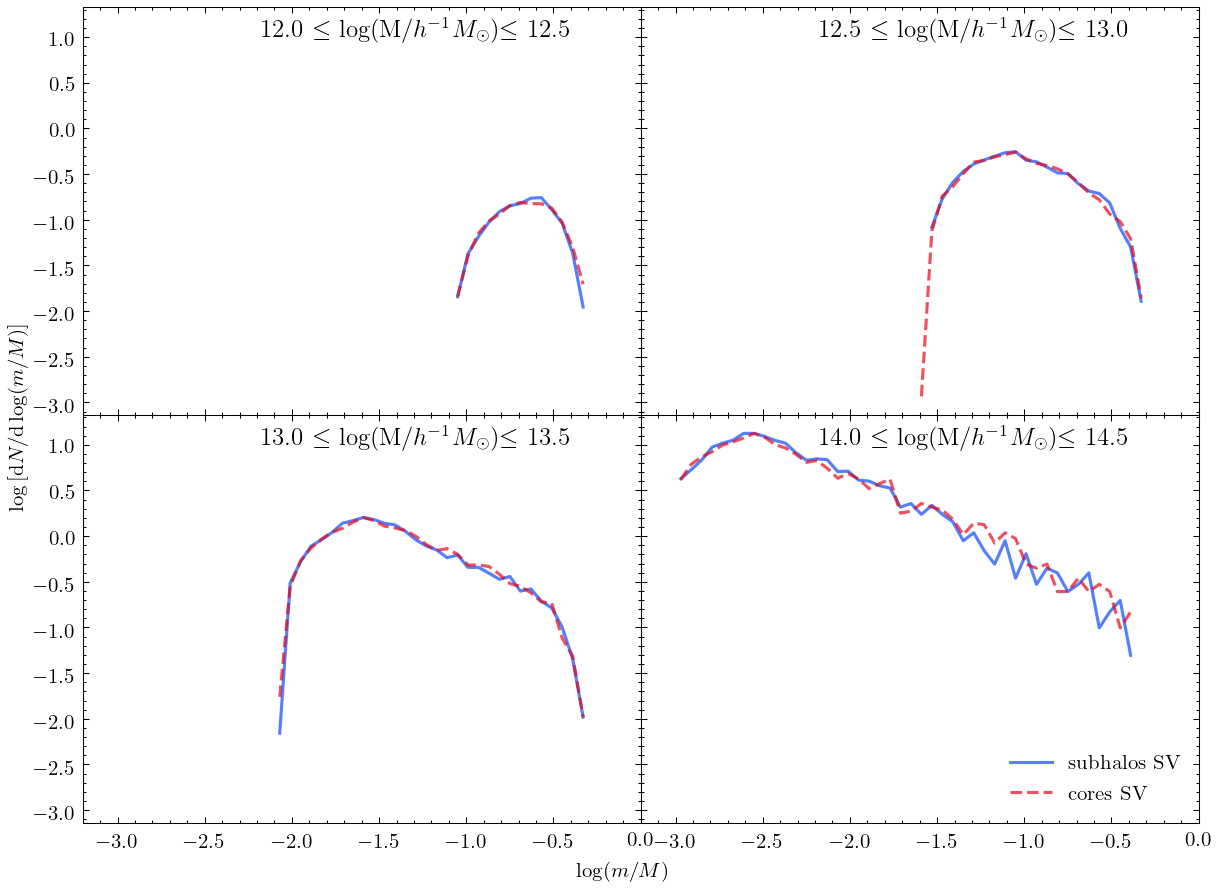

In [152]:
#z=0
subhalo_core_mass_plots(A=0.9, zeta=0.005, M1=0, M2=0, plotFlag=1, residualRange=(0,0), normLogCntsFlag=True, logmOverMFlag=1, phaseMergedFlag=0, normCnts=0, MdepPlots=1, vlinepart=0, normScalar=1, normBinsize=1, shPlot=1, part100cutFlag=1, plotHMFlag=False);
# plt.savefig('/home/isultan/projects/halomassloss/core_catalog_mevolved/Paper2Figs/res_mass_fn_z1.pdf')

nH_sh_param:  40628
nH_cSV_param:  40628
nH_cHM_param:  39505

nH_sh_param:  14286
nH_cSV_param:  14286
nH_cHM_param:  13733

nH_sh_param:  4797
nH_cSV_param:  4797
nH_cHM_param:  4738

nH_sh_param:  337
nH_cSV_param:  337
nH_cHM_param:  348



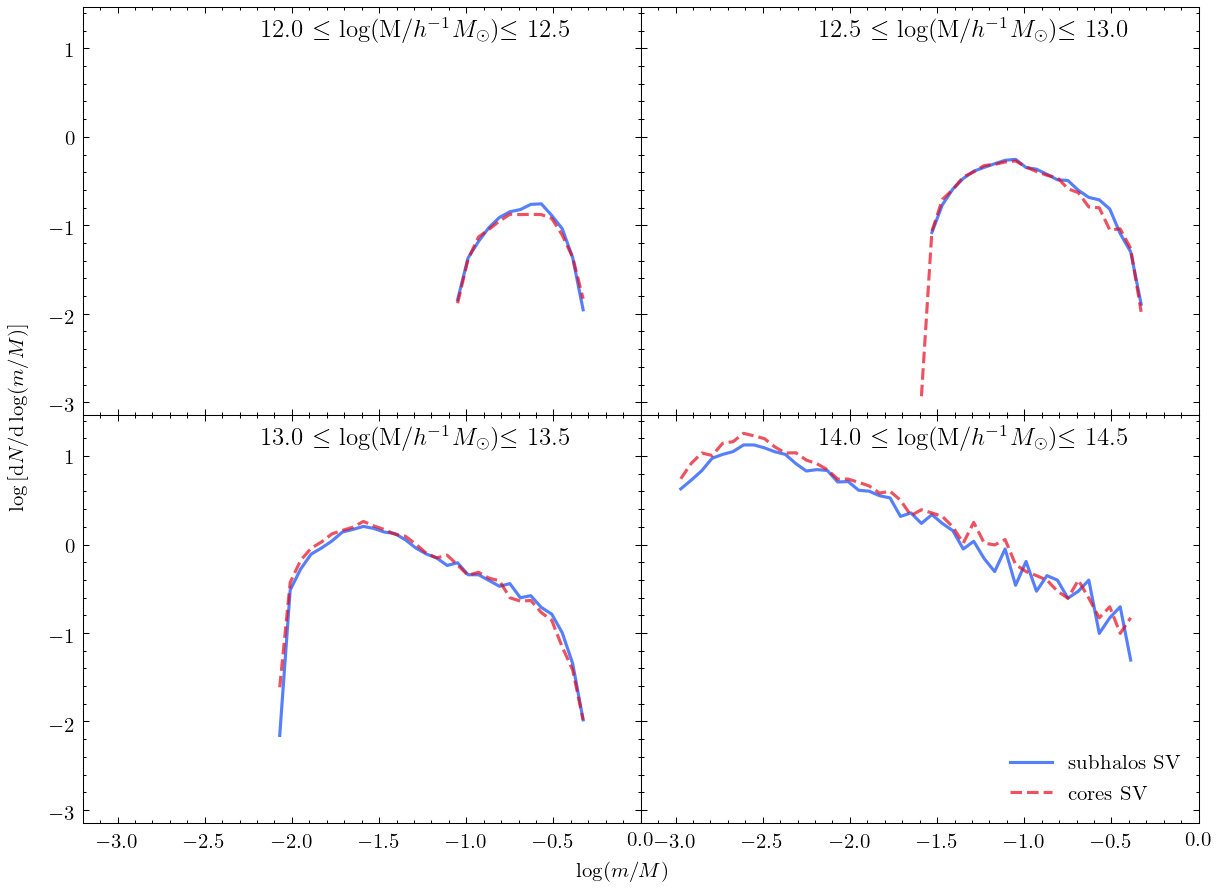

In [166]:
#z=0
subhalo_core_mass_plots(A=1.3, zeta=0.15, M1=0, M2=0, plotFlag=1, residualRange=(0,0), normLogCntsFlag=True, logmOverMFlag=1, phaseMergedFlag=0, normCnts=0, MdepPlots=1, vlinepart=0, normScalar=1, normBinsize=1, shPlot=1, part100cutFlag=1, plotHMFlag=False);

nH_sh_param:  40628
nH_cSV_param:  40628
nH_cHM_param:  39505

nH_sh_param:  14286
nH_cSV_param:  14286
nH_cHM_param:  13733

nH_sh_param:  4797
nH_cSV_param:  4797
nH_cHM_param:  4738

nH_sh_param:  337
nH_cSV_param:  337
nH_cHM_param:  348



/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in subtract
/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in subtract


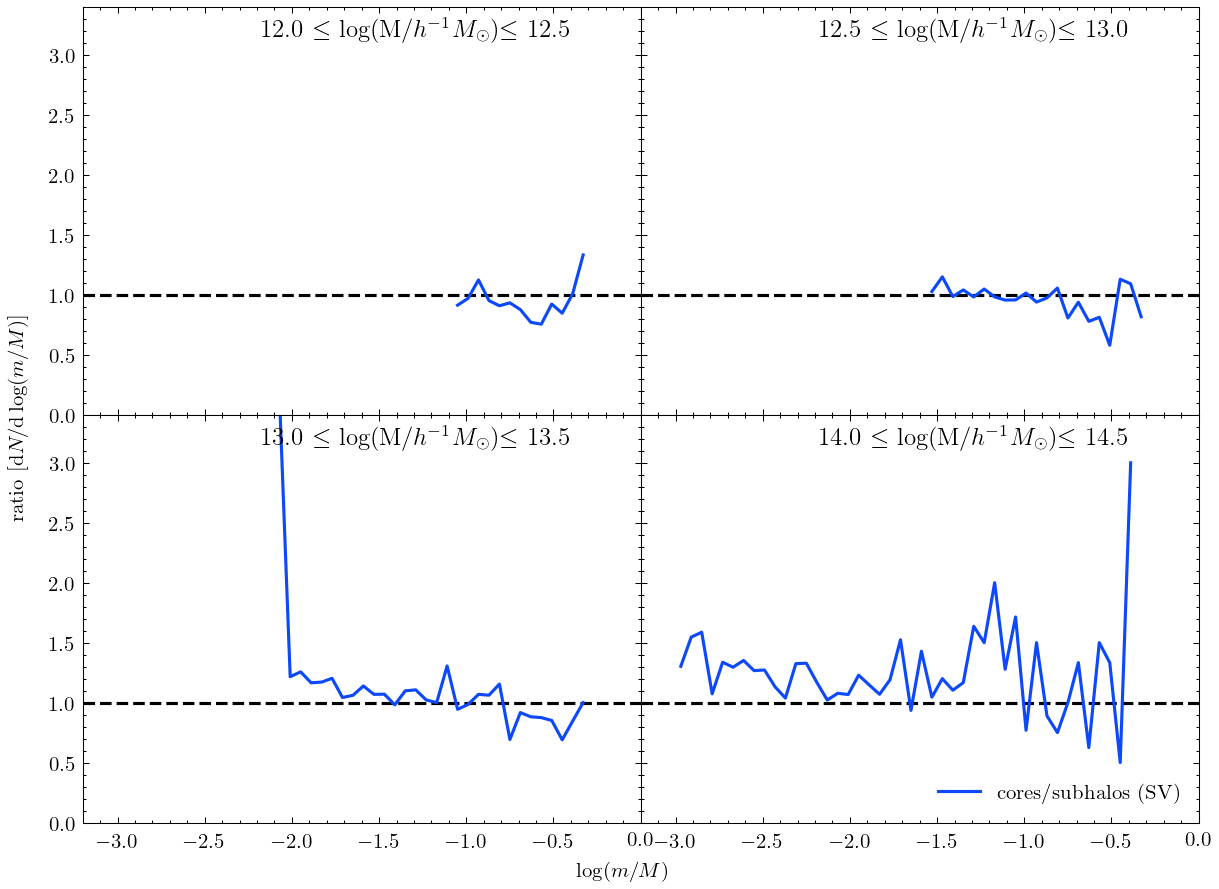

In [171]:
#z=0
subhalo_core_mass_plots(A=1.3, zeta=0.15, M1=0, M2=0, plotFlag=1, residualRange=(0,0), normLogCntsFlag=True, logmOverMFlag=1, phaseMergedFlag=0, normCnts=0, MdepPlots=1, vlinepart=0, normScalar=1, normBinsize=1, shPlot=1, part100cutFlag=1, plotHMFlag=False, ratio=True);

nH_sh_param:  40628
nH_cSV_param:  40628
nH_cHM_param:  39505

nH_sh_param:  14286
nH_cSV_param:  14286
nH_cHM_param:  13733

nH_sh_param:  4797
nH_cSV_param:  4797
nH_cHM_param:  4738

nH_sh_param:  337
nH_cSV_param:  337
nH_cHM_param:  348



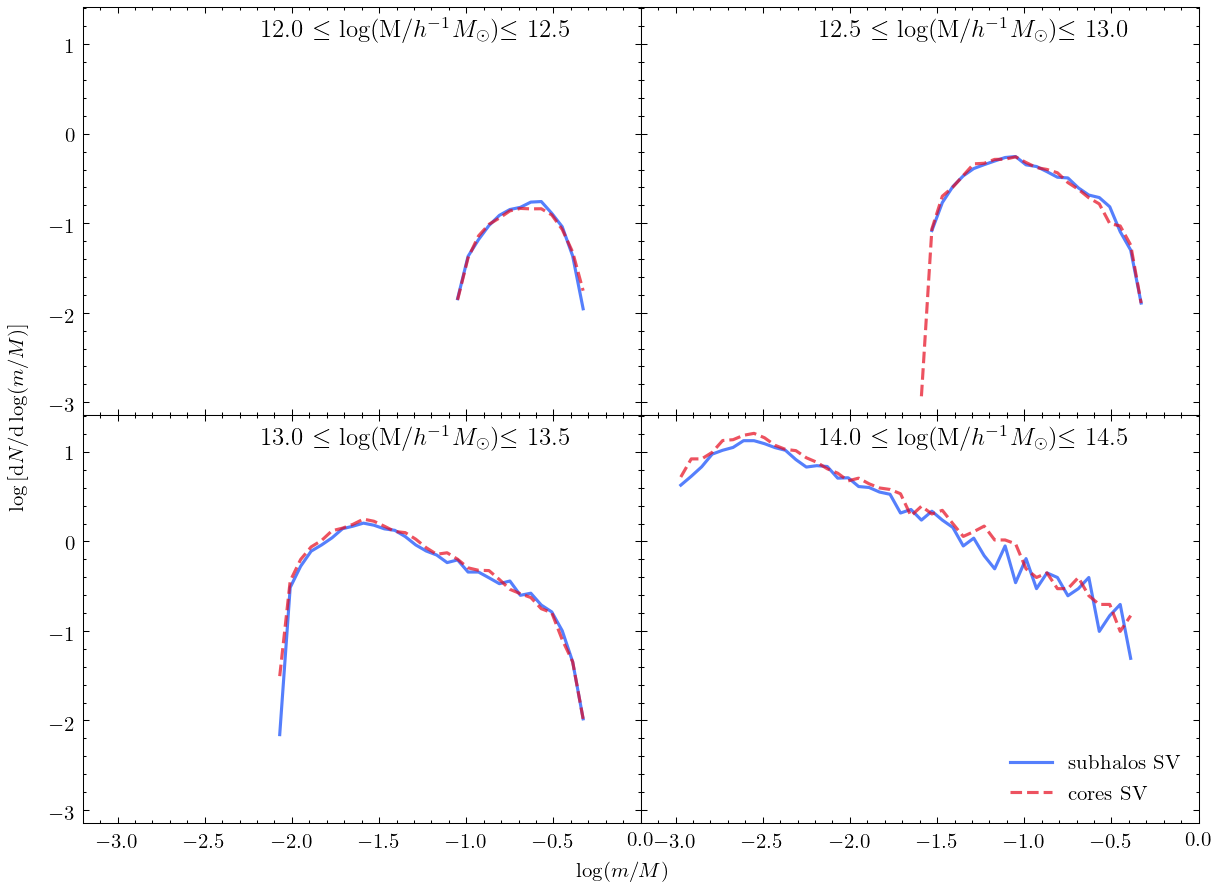

In [167]:
#z=0
subhalo_core_mass_plots(A=1.1, zeta=0.1, M1=0, M2=0, plotFlag=1, residualRange=(0,0), normLogCntsFlag=True, logmOverMFlag=1, phaseMergedFlag=0, normCnts=0, MdepPlots=1, vlinepart=0, normScalar=1, normBinsize=1, shPlot=1, part100cutFlag=1, plotHMFlag=False);

In [170]:
#z=0
for A in [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4]:
    for zeta in [0.001, 0.005, 0.01, 0.02, 0.04, 0.07, 0.08, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3]:
        print A,zeta
        subhalo_core_mass_plots(A=A, zeta=zeta, M1=0, M2=0, plotFlag=1, residualRange=(0,0), normLogCntsFlag=True, logmOverMFlag=1, phaseMergedFlag=0, normCnts=0, MdepPlots=1, vlinepart=0, normScalar=1, normBinsize=1, shPlot=1, part100cutFlag=1, plotHMFlag=False);
        plt.savefig('Paper2Figs/paramexploration_moverMplots/{}_{}_z0.pdf'.format(A, zeta))
        plt.close()

0.4 0.001
nH_sh_param:  40628
nH_cSV_param:  40628
nH_cHM_param:  39505

nH_sh_param:  14286
nH_cSV_param:  14286
nH_cHM_param:  13733

nH_sh_param:  4797
nH_cSV_param:  4797
nH_cHM_param:  4738

nH_sh_param:  337
nH_cSV_param:  337
nH_cHM_param:  348

0.4 0.005
nH_sh_param:  40628
nH_cSV_param:  40628
nH_cHM_param:  39505

nH_sh_param:  14286
nH_cSV_param:  14286
nH_cHM_param:  13733

nH_sh_param:  4797
nH_cSV_param:  4797
nH_cHM_param:  4738

nH_sh_param:  337
nH_cSV_param:  337
nH_cHM_param:  348

0.4 0.01
nH_sh_param:  40628
nH_cSV_param:  40628
nH_cHM_param:  39505

nH_sh_param:  14286
nH_cSV_param:  14286
nH_cHM_param:  13733

nH_sh_param:  4797
nH_cSV_param:  4797
nH_cHM_param:  4738

nH_sh_param:  337
nH_cSV_param:  337
nH_cHM_param:  348

0.4 0.02
nH_sh_param:  40628
nH_cSV_param:  40628
nH_cHM_param:  39505

nH_sh_param:  14286
nH_cSV_param:  14286
nH_cHM_param:  13733

nH_sh_param:  4797
nH_cSV_param:  4797
nH_cHM_param:  4738

nH_sh_param:  337
nH_cSV_param:  337
nH_cHM_par

nH_sh_param:  351750
nH_cSV_param:  351750
nH_cHM_param:  308529

nH_sh_param:  33812
nH_cSV_param:  33812
nH_cHM_param:  30462

nH_sh_param:  2246
nH_cSV_param:  2246
nH_cHM_param:  2078

nH_sh_param:  29
nH_cSV_param:  29
nH_cHM_param:  18



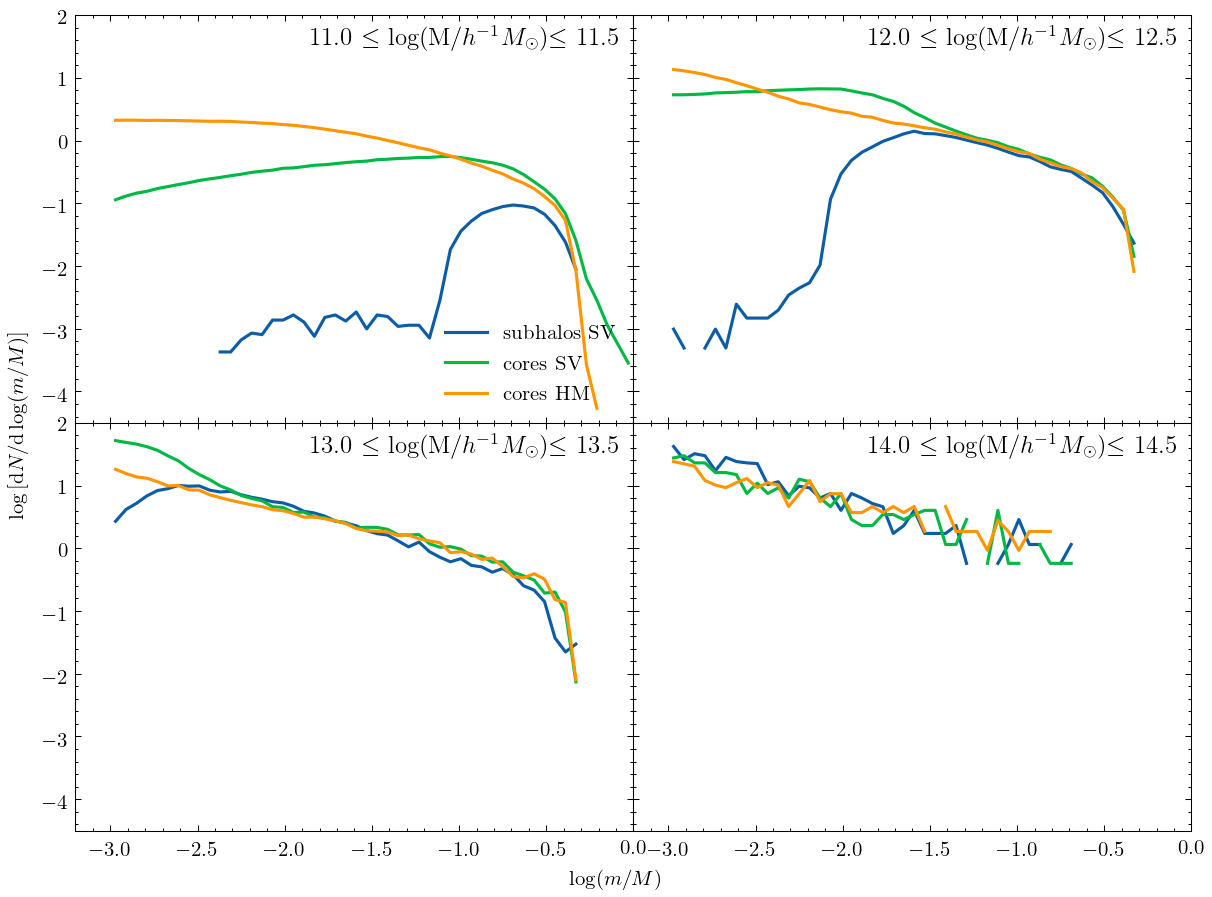

In [21]:
#z=1
subhalo_core_mass_plots(A=0.9, zeta=0.005, M1=0, M2=0, plotFlag=1, residualRange=(0,0), normLogCntsFlag=True, logmOverMFlag=1, phaseMergedFlag=0, normCnts=0, MdepPlots=1, vlinepart=0, normScalar=1, normBinsize=1, shPlot=1, part100cutFlag=0);
# plt.savefig('/home/isultan/projects/halomassloss/core_catalog_mevolved/Paper2Figs/res_mass_fn_z1.pdf')

nH_sh_param:  351750
nH_cSV_param:  351750
nH_cHM_param:  308529

nH_sh_param:  33812
nH_cSV_param:  33812
nH_cHM_param:  30462

nH_sh_param:  2246
nH_cSV_param:  2246
nH_cHM_param:  2078

nH_sh_param:  29
nH_cSV_param:  29
nH_cHM_param:  18



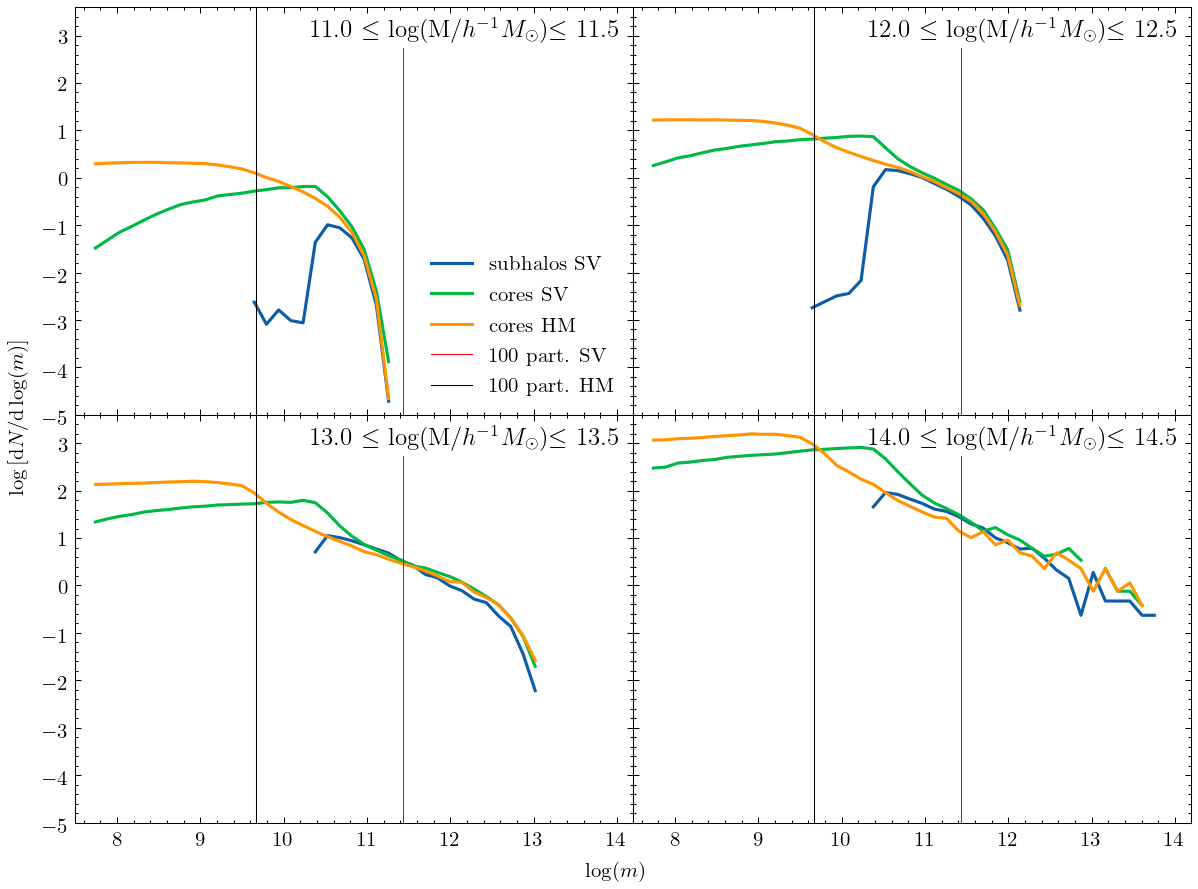

In [23]:
#z=1
subhalo_core_mass_plots(A=0.9, zeta=0.005, M1=0, M2=0, plotFlag=1, residualRange=(0,0), normLogCntsFlag=True, logmOverMFlag=0, phaseMergedFlag=0, normCnts=0, MdepPlots=1, vlinepart=1, normScalar=1, normBinsize=1, shPlot=1, part100cutFlag=0);
plt.savefig('/home/isultan/projects/halomassloss/core_catalog_mevolved/Paper2Figs/res_mass_fn_z1_m.pdf')

nH_sh_param:  319477
nH_cSV_param:  319477
nH_cHM_param:  313645

nH_sh_param:  40628
nH_cSV_param:  40628
nH_cHM_param:  39505



/home/isultan/projects/itk/itk.py:84: RuntimeWarning: divide by zero encountered in log10
  cnts = np.log10(cnts)


nH_sh_param:  4797
nH_cSV_param:  4797
nH_cHM_param:  4738

nH_sh_param:  337
nH_cSV_param:  337
nH_cHM_param:  348



/home/isultan/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


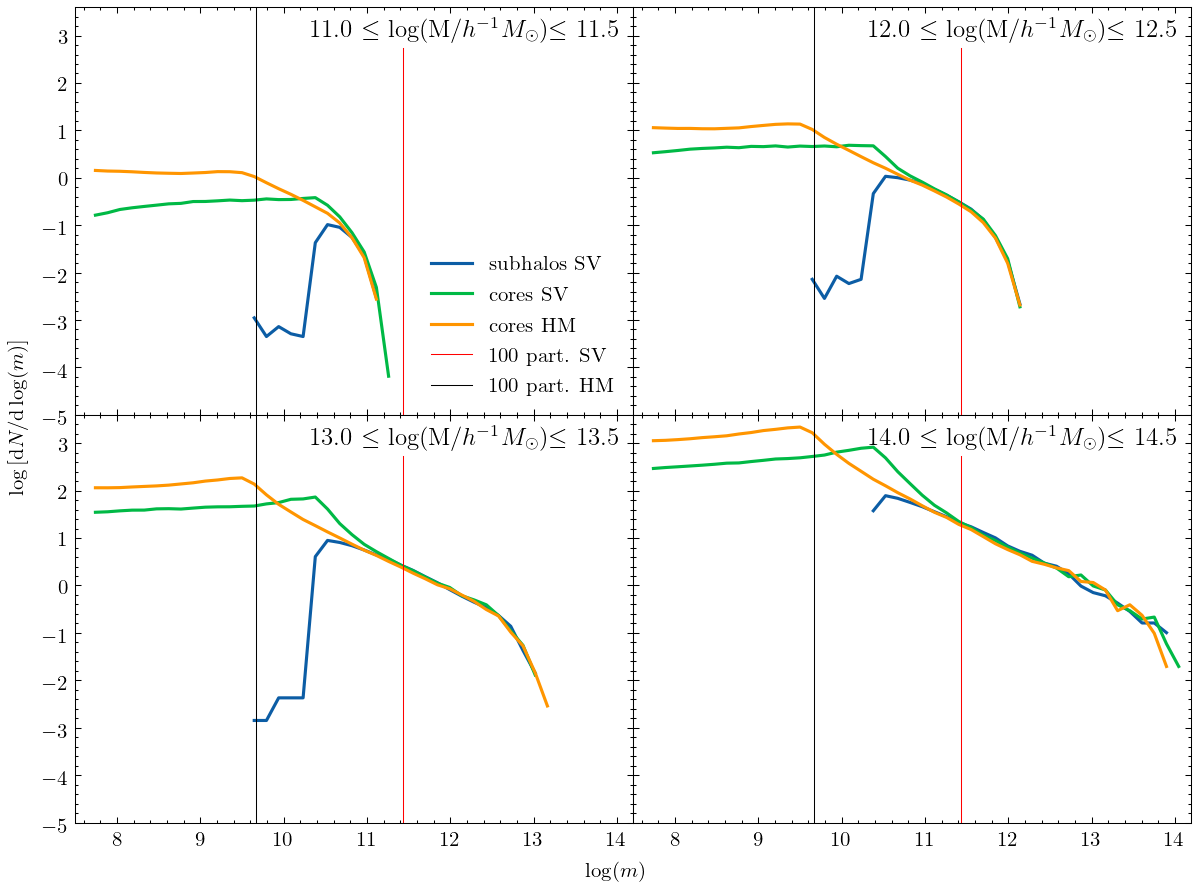

In [11]:
#z=0
subhalo_core_mass_plots(A=0.9, zeta=0.005, M1=0, M2=0, plotFlag=1, residualRange=(0,0), normLogCntsFlag=True, logmOverMFlag=0, phaseMergedFlag=0, normCnts=0, MdepPlots=1, vlinepart=1, normScalar=1, normBinsize=1, shPlot=1, part100cutFlag=0);
plt.savefig('/home/isultan/projects/halomassloss/core_catalog_mevolved/Paper2Figs/res_mass_fn_z0_m.pdf')

nH_sh_param:  319477
nH_cSV_param:  319477
nH_cHM_param:  313645

nH_sh_param:  40628
nH_cSV_param:  40628
nH_cHM_param:  39505

nH_sh_param:  4797
nH_cSV_param:  4797
nH_cHM_param:  4738

nH_sh_param:  337
nH_cSV_param:  337
nH_cHM_param:  348



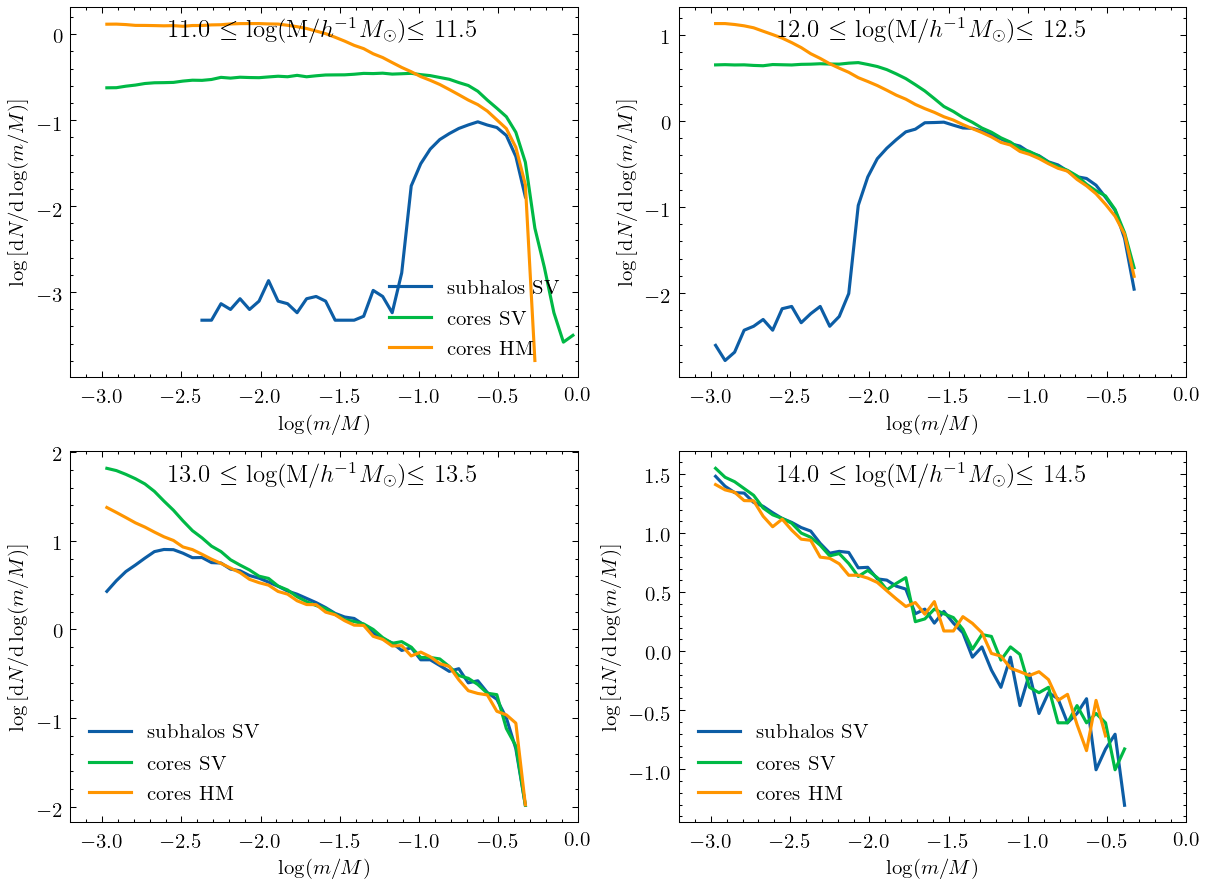

In [91]:
#z=0 M/m
subhalo_core_mass_plots(A=0.9, zeta=0.005, M1=0, M2=0, plotFlag=1, residualRange=(0,0), normLogCntsFlag=True, logmOverMFlag=1, phaseMergedFlag=0, normCnts=0, MdepPlots=1, vlinepart=0, normScalar=1, normBinsize=1, shPlot=1, part100cutFlag=0);
# plt.savefig('/home/isultan/projects/halomassloss/core_catalog_mevolved/Paper2Figs/res_mass_fn_z0_m.pdf')

nH_sh_param:  319477
nH_cSV_param:  319477
nH_cHM_param:  313645

nH_sh_param:  40628
nH_cSV_param:  40628
nH_cHM_param:  39505



/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in subtract
/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in subtract
/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in subtract
/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in subtract


nH_sh_param:  4797
nH_cSV_param:  4797
nH_cHM_param:  4738

nH_sh_param:  337
nH_cSV_param:  337
nH_cHM_param:  348



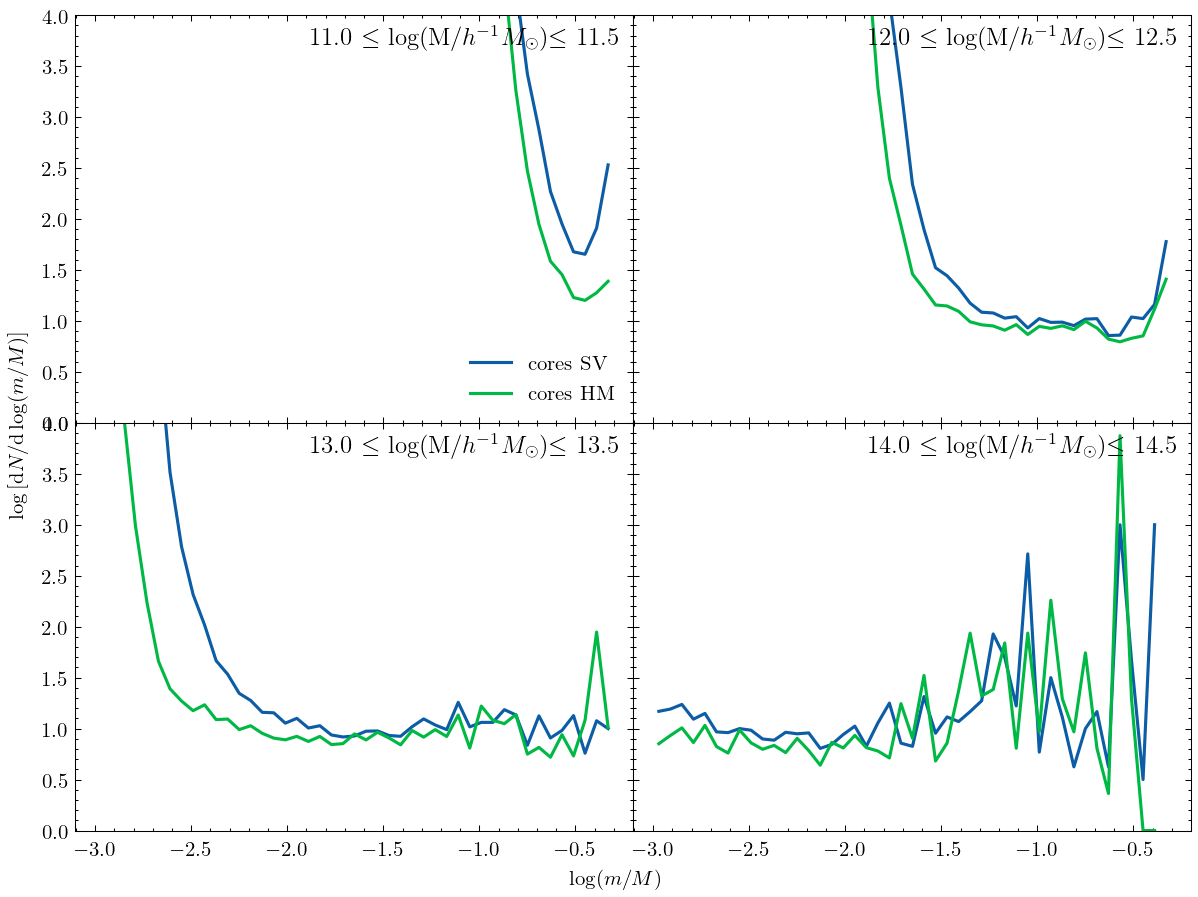

In [71]:
#z=0 M/m ratio
subhalo_core_mass_plots(A=0.9, zeta=0.005, M1=0, M2=0, plotFlag=1, residualRange=(0,0), normLogCntsFlag=True, logmOverMFlag=1, phaseMergedFlag=0, normCnts=0, MdepPlots=1, vlinepart=0, normScalar=1, normBinsize=1, shPlot=1, part100cutFlag=0, ratio=1);
# plt.savefig('/home/isultan/projects/halomassloss/core_catalog_mevolved/Paper2Figs/res_mass_fn_z0_m.pdf')